# Siamese Network with Tensorflow

Ref: [Image similarity estimation using a Siamese Network with a triplet loss](https://keras.io/examples/vision/siamese_network/)


----


Maybe it help u with ipynb_checkpoints problem in dataset directory
1. Use `ls */.ipynb_checkpoints` to list if there are ipynb_checkpoints.
2. Use `rm -r */.ipynb_checkpoints` to remove all ipynb_checkpoints.

## Import required packages

In [1]:
import tensorflow as tf

# print tf log
# tf.debugging.set_log_device_placement(True)

# Hide GPU from visible devices
# tf.config.set_visible_devices([], 'GPU')

In [2]:
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model

import matplotlib.pyplot as plt
from itertools import permutations

## Load FaceNet embedding model

In [3]:
from facenet.facenet import load_model as load_facenet_model

In [4]:
# Load FaceNet
facenet = load_facenet_model("facenet/facenet_weights.h5")
target_shape = facenet.input_shape[1:3]
print(target_shape)

(160, 160)


## Create dataset

Edit this section to match your dataset

In [5]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [6]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])

### CASIA Dataset

In [7]:
img_paths = list()
for i in range(3):
    subject_id = str(i).zfill(3)
    subject_path = f"dataset/casia_cropped/{subject_id}"
    print(subject_path)
    for j in range(5):
        img_path = f"{subject_path}/{subject_id}_{j}.jpg"
        img_paths.append(img_path)

dataset/casia_cropped/000
dataset/casia_cropped/001
dataset/casia_cropped/002


In [8]:
img_paths[1].split("/")[-2]

'000'

In [9]:
anchor_paths = list()
positive_paths = list()
negative_paths = list()

for anchor_path, positive_path, negative_path in permutations(img_paths, 3):
    idx = -2
    anchor_subject = anchor_path.split("/")[idx]
    positive_subject = positive_path.split("/")[idx]
    negative_subject = negative_path.split("/")[idx]
    
    if (anchor_subject == positive_subject) and (anchor_subject != negative_subject):
        anchor_paths.append(str(anchor_path))
        positive_paths.append(str(positive_path))
        negative_paths.append(str(negative_path))

In [10]:
image_count = len(anchor_paths)
print(image_count)

600


In [11]:
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_paths)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_paths)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_paths)

In [12]:
casia_dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
casia_dataset = casia_dataset.shuffle(buffer_size=1024)
casia_dataset = casia_dataset.map(preprocess_triplets)

# Comment below line if you are going to split the dataset
casia_dataset = casia_dataset.batch(32, drop_remainder=False).prefetch(8)

In [13]:
# split train-test

# train_dataset = dataset.take(round(image_count * 0.8))
# val_dataset = dataset.skip(round(image_count * 0.8))

# train_dataset = train_dataset.batch(32, drop_remainder=False)
# train_dataset = train_dataset.prefetch(8)

# val_dataset = val_dataset.batch(32, drop_remainder=False)
# val_dataset = val_dataset.prefetch(8)

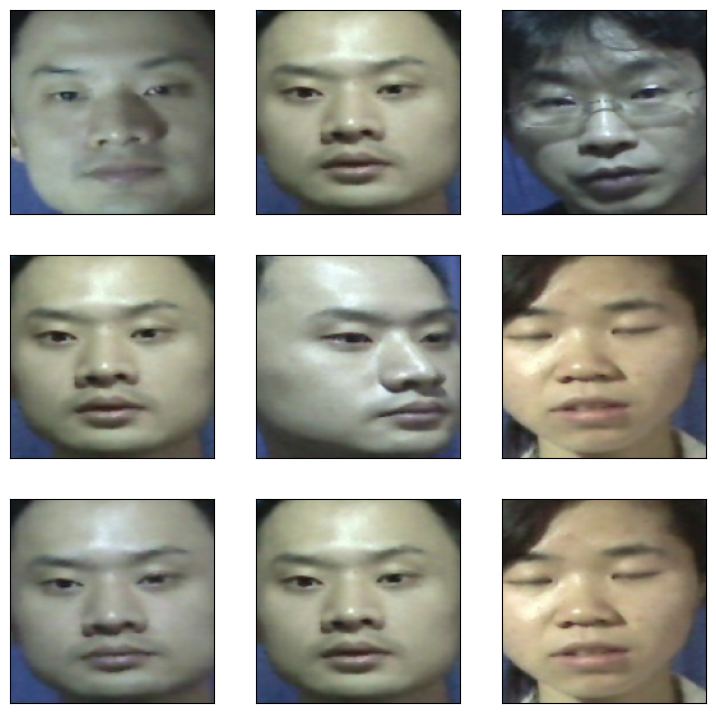

In [14]:
visualize(*list(casia_dataset.take(1).as_numpy_iterator())[0])

### GreenInn Dataset

In [15]:
img_paths = list()
for i in range(3):
    subject_id = str(i).zfill(3)
    subject_path = f"dataset/greeninn/{subject_id}"
    print(subject_path)
    for j in range(3):
        img_path = f"{subject_path}/{subject_id}_{j}.jpg"
        img_paths.append(img_path)

dataset/greeninn/000
dataset/greeninn/001
dataset/greeninn/002


In [16]:
anchor_paths = list()
positive_paths = list()
negative_paths = list()

for anchor_path, positive_path, negative_path in permutations(img_paths, 3):
    idx = -2
    anchor_subject = anchor_path.split("/")[idx]
    positive_subject = positive_path.split("/")[idx]
    negative_subject = negative_path.split("/")[idx]
    
    if (anchor_subject == positive_subject) and (anchor_subject != negative_subject):
        anchor_paths.append(str(anchor_path))
        positive_paths.append(str(positive_path))
        negative_paths.append(str(negative_path))

In [17]:
image_count = len(anchor_paths)
print(image_count)

108


In [18]:
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_paths)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_paths)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_paths)

In [19]:
greeninn_dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
greeninn_dataset = greeninn_dataset.shuffle(buffer_size=1024)
greeninn_dataset = greeninn_dataset.map(preprocess_triplets)

greeninn_dataset = greeninn_dataset.batch(32, drop_remainder=False).prefetch(8)

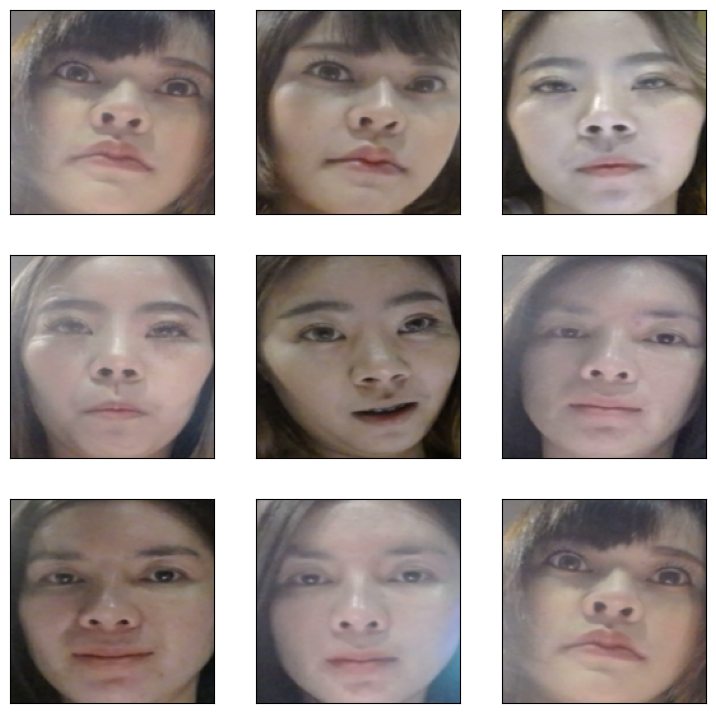

In [20]:
visualize(*list(greeninn_dataset.take(1).as_numpy_iterator())[0])

## Siamese Network and Triplet Loss

In [21]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.cosine_loss = tf.keras.losses.CosineSimilarity(axis=-1)

    def call(self, anchor, positive, negative):
        
        # Eulidean distance
        # ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        # an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        
        # Cosine Distance
        ap_distance = self.cosine_loss(anchor, positive) + 1
        an_distance = self.cosine_loss(anchor, negative) + 1
        
        return (ap_distance, an_distance)
    

def build_siamese_network(embedding_model):

    anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
    positive_input = layers.Input(name="positive", shape=target_shape + (3,))
    negative_input = layers.Input(name="negative", shape=target_shape + (3,))

    distances = DistanceLayer()(
        embedding_model(anchor_input),
        embedding_model(positive_input),
        embedding_model(negative_input),
    )

    siamese_network = Model(
        inputs=[anchor_input, positive_input, negative_input], outputs=distances
    )
    
    return siamese_network

In [22]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

## Training

Todo: 
- add early stop or set appropriate number of epochs
- save model weight (only facenet)

In [23]:
siamese_network = build_siamese_network(facenet)
train_dataset = casia_dataset
val_dataset = greeninn_dataset

siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001), weighted_metrics=[])
siamese_model.fit(train_dataset, epochs=5, validation_data=val_dataset)

Epoch 1/5
19/19 [==============================] - 33s 747ms/step - loss: 0.0116 - val_loss: 0.2960
Epoch 2/5
19/19 [==============================] - 10s 506ms/step - loss: 0.0000e+00 - val_loss: 0.3602
Epoch 3/5
19/19 [==============================] - 10s 506ms/step - loss: 0.0000e+00 - val_loss: 0.3668
Epoch 4/5
19/19 [==============================] - 10s 501ms/step - loss: 0.0000e+00 - val_loss: 0.3685
Epoch 5/5
19/19 [==============================] - 10s 504ms/step - loss: 0.0000e+00 - val_loss: 0.3666


In [24]:
siamese_network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor (InputLayer)            [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 positive (InputLayer)          [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 negative (InputLayer)          [(None, 160, 160, 3  0           []                               
                                )]                                                            

In [25]:
facenet.save_weights("facenet_weight_test.h5")